<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations - v1
In this notebook I'm going to explore options for visualising the weight changes across the network as it learns. There's a number of different interesting things that we focus on for the duration of training:
* how fast/slow the weights are getting updates?
* what proportion of weights are getting updated?
* is learning moving in a consistent direction or is it oscillating?
* what's the learning rate that ADAM is currently using?

For the first experiments, I'm going to focus on the issue of whether learning is oscillationg, by examining the sign of individual weight changes.

In [58]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# First, some basic helper methods
def plot_fit(x, y, model, history = None):
  y_predict = model.predict(x)

  pnum = 1
  if history != None:
    pnum += 1

  plt.figure(layout='constrained')
  plt.subplot(1,pnum,1)
  plt.plot(x, y, color='blue', label="Truth")
  plt.plot(x, y_predict, color='orange',label="Prediction")
  plt.legend()
  if history != None:
    plt.subplot(1,pnum,2)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_interval == 0:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

## Simple Curve
As a first exercise, let's simply fit against a very simple curve. This is useful because it's easier to force it into oscillation so we can compare good and bad training regimes.



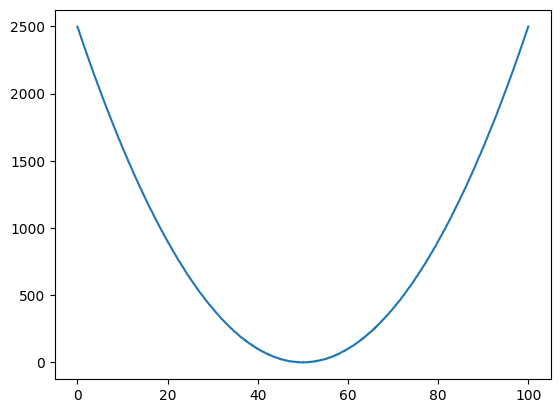

In [3]:
# Define curve to fit
x = np.linspace(0.0, 100.0, 1000)
#y = np.sin(x/100.0 * np.pi * 5)
y = (x-50)**2 + np.random.normal(size=(1000,))
plt.plot(x,y)

In [ ]:


W = tf.Variable(tf.random.normal((100, 5),dtype=tf.float64),name='W')
X = tf.Variable(tf.random.normal((100, 5),dtype=tf.float64),name='X')
b = tf.Variable(tf.random.normal((1,   5),dtype=tf.float64),name='b')

grads = np.ones((1,100*5 + 100*5 + 1*5));

opt = RecordingOptimizer(learning_rate=0.01)
opt.apply_gradients(zip(grads, [X,W,b]))

RecordingOptimizer.apply_gradients


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1005] vs. [100,5] [Op:Sub] name: 

Iteration 0 - loss: 1256933.8435615096
Iteration 1000 - loss: 557779.4886292251
Iteration 2000 - loss: 557776.3264285595
Iteration 3000 - loss: 557776.3265501902
Iteration 4000 - loss: 557778.5174129655
32/32 [==============================] - 0s 3ms/step


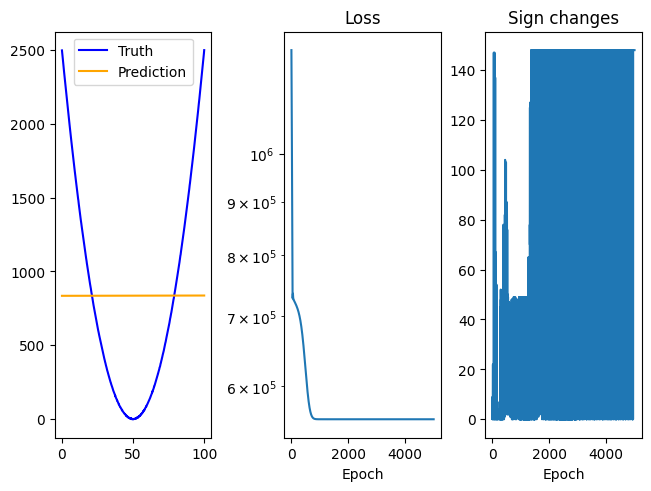

In [91]:
# First, let's try with a simple custom training loop
class RecordingOptimizer(tf.keras.optimizers.Adam):
    def __init__(self, **kwargs):
      super(RecordingOptimizer, self).__init__(**kwargs)
      self._prev_grads = None
      self._prev_deltas = None
      self._sign_change_counts = []

    # Per iteration we get a zip list containing entries:
    #  - grads: (1, 128), vars: (1, 128)   # layer 1 W
    #  - grads: (128,),   vars: (128,)     # layer 1 b
    #  - grads: (128, 1), vars: (128, 1)   # layer 2 W
    #  - grads: (1,),     vars: (1,)       # layer 2 b
    def apply_gradients(self, grads_and_vars):
      #print(f"RecordingOptimizer.apply_gradients")
      grads, vars = zip(*grads_and_vars)
      deltas = None
      if self._prev_grads != None:
        deltas = [cur - prev for cur, prev in zip(grads, self._prev_grads)]
        #print(f"deltas: {deltas[0]}")
        #print(f"deltas: min={np.min(deltas[0])}, max={np.max(deltas[0])}, mean={np.mean(deltas[0])}")
      if self._prev_deltas != None:
        delta_sign_changes = [np.sign(cur) != np.sign(prev) for cur, prev in zip(deltas, self._prev_deltas)]
        count = 0
        for sign_change in delta_sign_changes:
          count += np.sum(sign_change)
        self._sign_change_counts.append(count)
        #print(f"signs:  {count}")
      if deltas != None:
        self._prev_deltas = deltas
      self._prev_grads = grads

      super().apply_gradients(zip(grads,vars))

    def history(self):
      return {
          "grad_sign_changes": self._sign_change_counts
      }

loss_fn = tf.keras.losses.MSE
opt = RecordingOptimizer(learning_rate=0.01)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
history_loss = []
for iter in range(5000):
  with tf.GradientTape() as tape:
    loss = loss_fn(model(x), y)
  if iter % 1000 == 0:
    print(f"Iteration {iter} - loss: {np.mean(loss)}")
  history_loss.append(np.mean(loss));
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
history2 = opt.history()


y_predict = model.predict(x)
plt.figure(layout='constrained')
plt.subplot(1,3,1)
plt.plot(x, y, color='blue', label="Truth")
plt.plot(x, y_predict, color='orange',label="Prediction")
plt.legend()
plt.subplot(1,3,2)
plt.plot(history_loss)
plt.title('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.subplot(1,3,3)
plt.plot(history2['grad_sign_changes'])
plt.title('Sign changes')
plt.xlabel('Epoch')
plt.show()

In [90]:
# Now let's attempt to use this in a normal model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
opt = RecordingOptimizer(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
#history = model.fit(x, y, epochs=50, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(10)])
history = model.fit(x, y, epochs=50, batch_size=len(x), verbose=0)

TypeError: <tf.Tensor 'gradient_tape/sequential_57/dense_114/MatMul/MatMul:0' shape=(1, 128) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'gradient_tape/sequential_57/dense_114/MatMul/MatMul:0' shape=(1, 128) dtype=float32> was defined here:
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-90-a7094fa33ad1>", line 11, in <cell line: 11>
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 888, in _call
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 695, in _initialize
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 178, in trace_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 283, in _maybe_define_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 310, in _create_concrete_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/func_graph.py", line 1059, in func_graph_from_py_func
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 598, in wrapped_fn
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py", line 41, in autograph_handler
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1681, in run
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 3271, in call_for_each_replica
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 4069, in _call_for_each_replica
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/backprop.py", line 1066, in gradient
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/imperative_grad.py", line 67, in imperative_grad
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/backprop.py", line 148, in _gradient_function
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/math_grad.py", line 1702, in _MatMulGrad
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/math_grad.py", line 1683, in _MatMulGradAgainstSecondOnly
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 6192, in mat_mul
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/func_graph.py", line 670, in _create_op_internal
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def

The tensor <tf.Tensor 'gradient_tape/sequential_57/dense_114/MatMul/MatMul:0' shape=(1, 128) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=train_function, id=134369476716448), which is out of scope.

It looks like trying to wrap the Optimizer to collect stats isn't going to work well. On first glance, it appears that the highly optimised TF classes use their computation graph not just for the loss function calculation, but also in how the gradients are applied. This seems to be evidenced also by the way that my custom loop is so much slower than using the standard model.fit() function (about 10x slower).

It appears that I will need to override Model.fit() instead, as per: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

## MNIST Image Classification
As a first exercise, I'll look at the weight updates

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")